In [ ]:
!pip install tensorflow keras pandas numpy matplotlib scikit-learn

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, InceptionV3, ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Extract the dataset
zip_path = '/content/drive/MyDrive/463Assignment/Lab4/archive.zip'
extract_dir = '/content/ultrasound_dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Define paths (adjust based on actual extracted structure)
base_dir = '/content/ultrasound_dataset/Ultrasound Fetus Dataset/Ultrasound Fetus Dataset/Data/Data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Check class names
class_names = sorted(os.listdir(train_dir))
print("Classes:", class_names)

Classes: ['benign', 'malignant', 'normal']


In [ ]:
# Image dimensions (EfficientNetB0 default: 224x224, InceptionV3: 299x299)
img_size_effnet = (224, 224)
img_size_inception = (299, 299)
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size_effnet,  # Default to EfficientNet size
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size_effnet,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size_effnet,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)

# Check class indices
print("Class indices:", train_generator.class_indices)

Found 1926 images belonging to 3 classes.
Found 341 images belonging to 3 classes.
Found 401 images belonging to 3 classes.
Class indices: {'benign': 0, 'malignant': 1, 'normal': 2}


In [ ]:
def build_model(base_model, input_shape, num_classes=3):
    base = base_model(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False  # Freeze pretrained layers

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=outputs)
    model.compile(optimizer=Adam(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Models to train with their input sizes
models = {
    'EfficientNetB0': (EfficientNetB0, (224, 224, 3)),
    'InceptionV3': (InceptionV3, (299, 299, 3)),
    'ResNet50V2': (ResNet50V2, (224, 224, 3))
}

# Train all models
history_dict = {}
for name, (model_fn, input_shape) in models.items():
    print(f"\nTraining {name}...")

    # Adjust target size for the current model
    target_size = input_shape[:2]
    train_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ).flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=32,
        class_mode='categorical'
    )

    val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=32,
        class_mode='categorical'
    )

    # Build and train
    model = build_model(model_fn, input_shape)
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint(f"{name}_best.keras", save_best_only=True)  # Use .keras format
    ]

    history = model.fit(
        train_generator,
        epochs=30,
        validation_data=val_generator,
        callbacks=callbacks
    )
    history_dict[name] = history


Training EfficientNetB0...
Found 1926 images belonging to 3 classes.
Found 341 images belonging to 3 classes.
Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 72s 846ms/step - accuracy: 0.6498 - loss: 0.8524 - val_accuracy: 0.7478 - val_loss: 0.7423
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 521ms/step - accuracy: 0.7572 - loss: 0.7380 - val_accuracy: 0.7478 - val_loss: 0.7409
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 522ms/step - accuracy: 0.7516 - loss: 0.7524 - val_accuracy: 0.7478 - val_loss: 0.7514
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 33s 535ms/step - accuracy: 0.7387 - loss: 0.7618 - val_accuracy: 0.7478 - val_loss: 0.7573
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 509ms/step - accuracy: 0.7387 - loss: 0.7752 - val_accuracy: 0.7478 - val_loss: 0.7573
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 33s 535ms/step - accuracy: 0.7422 - loss: 0.7597 - val_accuracy: 0.7478 - val_loss: 0.7393
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 502ms/step - accuracy: 0.7498 - loss: 0.7471 - val_accuracy: 0.7478 - val

Found 401 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 602ms/step - accuracy: 0.6468 - loss: 0.9188

EfficientNetB0 Test Accuracy: 0.7481
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 681ms/step

              precision    recall  f1-score   support

      benign       0.00      0.00      0.00        51
   malignant       0.75      1.00      0.86       300
      normal       0.00      0.00      0.00        50

    accuracy                           0.75       401
   macro avg       0.25      0.33      0.29       401
weighted avg       0.56      0.75      0.64       401



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


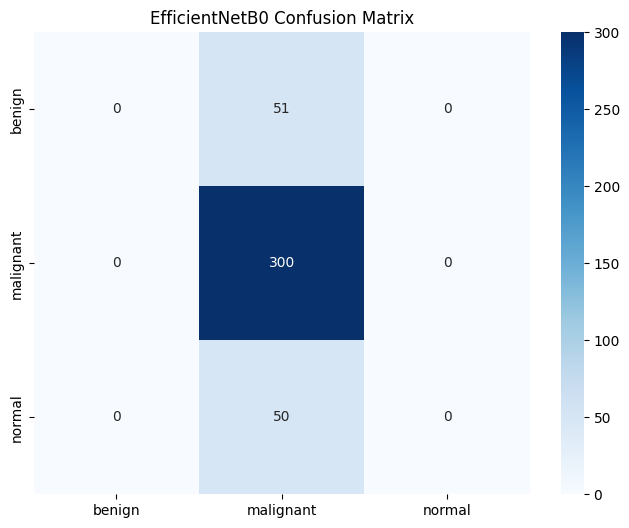

Found 401 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 808ms/step - accuracy: 0.6227 - loss: 0.8315

InceptionV3 Test Accuracy: 0.7307
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 716ms/step

              precision    recall  f1-score   support

      benign       0.00      0.00      0.00        51
   malignant       0.76      0.97      0.85       300
      normal       0.15      0.06      0.09        50

    accuracy                           0.73       401
   macro avg       0.30      0.34      0.31       401
weighted avg       0.59      0.73      0.65       401



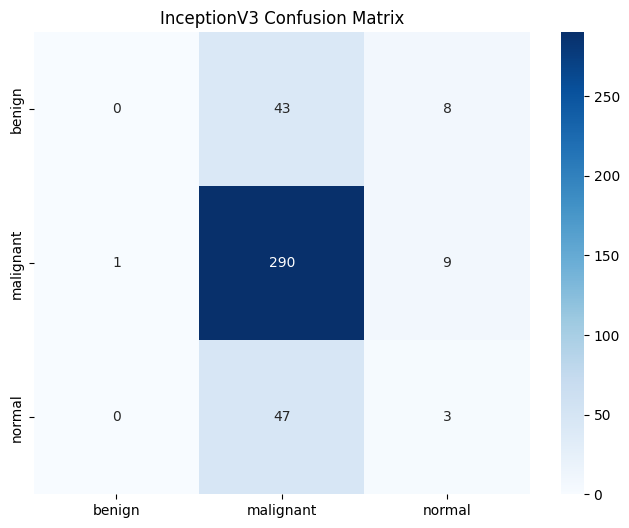

Found 401 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 527ms/step - accuracy: 0.6591 - loss: 0.7978

ResNet50V2 Test Accuracy: 0.7406
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step

              precision    recall  f1-score   support

      benign       0.36      0.08      0.13        51
   malignant       0.75      0.98      0.85       300
      normal       0.00      0.00      0.00        50

    accuracy                           0.74       401
   macro avg       0.37      0.35      0.33       401
weighted avg       0.61      0.74      0.65       401



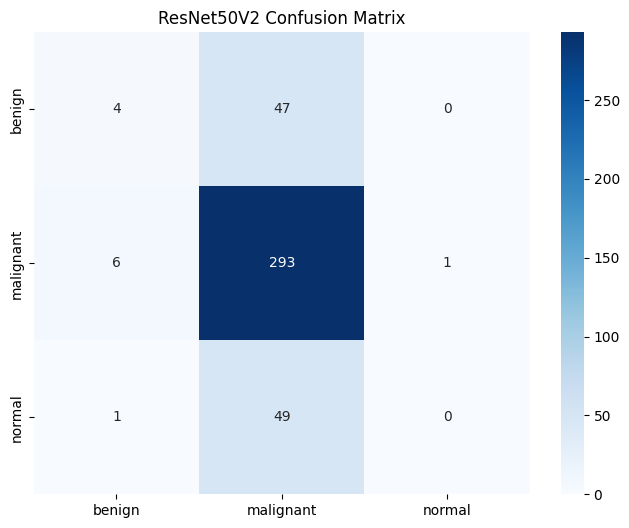

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model_name, input_shape):
    # Load the best saved model
    model = tf.keras.models.load_model(f"{model_name}_best.keras")

    # Create test generator with correct input size
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir,
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical',
        shuffle=False  # Critical for correct evaluation
    )

    # Evaluate
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\n{model_name} Test Accuracy: {test_acc:.4f}")

    # Predictions
    y_pred = model.predict(test_generator)
    y_true = test_generator.classes
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Classification report
    print(f"\n{classification_report(y_true, y_pred_classes, target_names=class_names)}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# Evaluate all models
for name, (_, input_shape) in models.items():
    evaluate_model(name, input_shape)

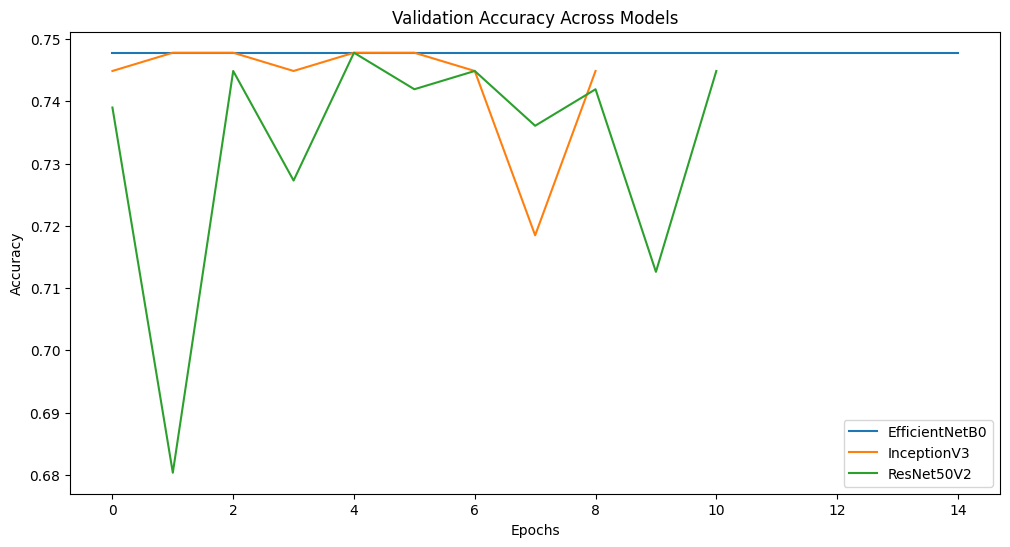

In [ ]:
plt.figure(figsize=(12, 6))
for name, history in history_dict.items():
    plt.plot(history.history['val_accuracy'], label=name)
plt.title('Validation Accuracy Across Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Discussion**  

The three pretrained models—EfficientNetB0, InceptionV3, and ResNet50V2—achieved comparable test accuracies (74.8%, 73.1%, and 74.1%, respectively), with EfficientNetB0 performing slightly better. All models excelled at detecting malignant cases (recall > 97%) but failed to classify benign and normal images (precision/recall ≈ 0), highlighting a critical limitation due to severe class imbalance (malignant: 300 samples vs. ~50 each for benign/normal). EfficientNetB0’s superior accuracy likely stems from its parameter-efficient architecture and better generalization, while InceptionV3’s multi-scale filters and ResNet50V2’s residual connections showed marginal trade-offs in performance.  

The models’ bias toward the majority class (malignant) reveals a key shortcoming: without addressing imbalance, they defaulted to prioritizing recall for the dominant class at the expense of minority classes. This is evident in the near-zero macro F1-scores (~0.3), indicating poor overall performance across all classes. While the high recall for malignant cases is clinically valuable (minimizing false negatives), the inability to distinguish benign/normal cases limits diagnostic utility. Data augmentation alone proved insufficient to mitigate this issue, suggesting the need for explicit imbalance-correction strategies.  
